In [549]:
# Importing Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, TimeSeriesSplit, GridSearchCV
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import cross_val_score, cross_val_predict

In [550]:
# Loading the data
sales_df = pd.read_csv('sales.csv')

In [551]:
# Exploring the data
sales_df.head(10)

,Unnamed: 0,store_ID,day_of_week,date,nb_customers_on_day,open,promotion,state_holiday,school_holiday,sales
0,425390,366,4,2013-04-18,517,1,0,0,0,4422
1,291687,394,6,2015-04-11,694,1,0,0,0,8297
2,411278,807,4,2013-08-29,970,1,1,0,0,9729
3,664714,802,2,2013-05-28,473,1,1,0,0,6513
4,540835,726,4,2013-10-10,1068,1,1,0,0,10882
5,687329,674,2,2013-03-19,1016,1,1,0,0,8406
6,600327,659,7,2014-06-08,0,0,0,0,0,0
7,96265,27,3,2014-07-16,1106,1,1,0,1,11162
8,364435,347,6,2013-05-11,448,1,0,0,0,5559
9,163146,288,2,2013-06-25,291,1,0,0,0,3997


In [552]:
sales_df.describe().round()

,Unnamed: 0,store_ID,day_of_week,nb_customers_on_day,open,promotion,school_holiday,sales
count,640840.0,640840.0,640840.0,640840.0,640840.0,640840.0,640840.0,640840.0
mean,355991.0,558.0,4.0,633.0,1.0,0.0,0.0,5777.0
std,205536.0,322.0,2.0,464.0,0.0,0.0,0.0,3851.0
min,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
25%,178076.0,280.0,2.0,405.0,1.0,0.0,0.0,3731.0
50%,355948.0,558.0,4.0,609.0,1.0,0.0,0.0,5746.0
75%,533959.0,837.0,6.0,838.0,1.0,1.0,0.0,7860.0
max,712044.0,1115.0,7.0,5458.0,1.0,1.0,1.0,41551.0


In [553]:
print(f"Shape:\n{sales_df.shape}\n")
print(f"Types:\n{sales_df.dtypes}")

Shape:
(640840, 10)

Types:
Unnamed: 0              int64
store_ID                int64
day_of_week             int64
date                   object
nb_customers_on_day     int64
open                    int64
promotion               int64
state_holiday          object
school_holiday          int64
sales                   int64
dtype: object


In [554]:
# Checking to see if every value in Unnamed: 0 is unique. Which will mean it's and 'id' column and we can drop it
if sales_df['Unnamed: 0'].unique().__len__() == sales_df.shape[0]:
    print(f"We should consider dropping 'Unnamed: 0' as it's an id or index column")

# Checking for missing data
print(sales_df.isnull().sum())

# Checking what the unique values in the 'state_holiday' column are
print(sales_df['state_holiday'].unique())

We should consider dropping 'Unnamed: 0' as it's an id or index column
Unnamed: 0             0
store_ID               0
day_of_week            0
date                   0
nb_customers_on_day    0
open                   0
promotion              0
state_holiday          0
school_holiday         0
sales                  0
dtype: int64
['0' 'a' 'c' 'b']


In [555]:
### FEATURE ENGINEERING AND PRE-PROCESSING

# Replace non-int data in the 'date' and 'state_holiday' columns with integers
# Converting the string values to integers
sales_df['state_holiday'] = LabelEncoder().fit_transform(sales_df['state_holiday'])

# Convert date to a datetime and then to Numerical value.
sales_df['date'] = pd.to_datetime(sales_df['date'])

#Extract individual features from the date
sales_df['day'] = sales_df['date'].dt.day
sales_df['month'] = sales_df['date'].dt.month
sales_df['year'] = sales_df['date'].dt.year

# Extracting weekend information from the day of the week
sales_df['is_weekend'] = sales_df['day_of_week'].apply(lambda x: 1 if x in [5, 6] else 0)

# Extracting quarter information from the day of the week
sales_df['quarter'] = sales_df['date'].dt.quarter

# Extracting some new features from the existing ones to see if they help improving the model
# We will drop 'customers_promo' and 'customers_weekend' as they are highly correlated with other features
# We will also drop 'promo_weekend' because it doesn't seem to be am important feature
sales_df['customers_promo'] = sales_df['nb_customers_on_day'] * sales_df['promotion']
sales_df['customers_weekend'] = sales_df['nb_customers_on_day'] * sales_df['is_weekend']
sales_df['promo_weekend'] = sales_df['promotion'] * sales_df['is_weekend']
sales_df['avg_customers_per_store'] = sales_df.groupby('store_ID')['nb_customers_on_day'].transform('mean')

# Checking the result
sales_df.head()

,Unnamed: 0,store_ID,day_of_week,date,nb_customers_on_day,open,promotion,state_holiday,school_holiday,sales,day,month,year,is_weekend,quarter,customers_promo,customers_weekend,promo_weekend,avg_customers_per_store
0,425390,366,4,2013-04-18,517,1,0,0,0,4422,18,4,2013,0,2,0,0,0,512.517065
1,291687,394,6,2015-04-11,694,1,0,0,0,8297,11,4,2015,1,2,0,694,0,558.138158
2,411278,807,4,2013-08-29,970,1,1,0,0,9729,29,8,2013,0,3,970,0,0,821.389171
3,664714,802,2,2013-05-28,473,1,1,0,0,6513,28,5,2013,0,2,473,0,0,431.602131
4,540835,726,4,2013-10-10,1068,1,1,0,0,10882,10,10,2013,0,4,1068,0,0,912.560847


In [556]:
### SORTING THE DATA AND CREATING LAG FEATURES ###
# Sort the data by date to ensure lagging works correctly
sorted_df = sales_df.sort_values(by='date')

# Create lag features for sales over multiple days (e.g., lag of 1, 7, 30 days)
sorted_df['sales_lag_1'] = sorted_df['sales'].shift(1)
sorted_df['sales_lag_7'] = sorted_df['sales'].shift(7)  # Sales from 7 days ago
sorted_df['sales_lag_30'] = sorted_df['sales'].shift(30)  # Sales from 30 days ago

# Create rolling mean features (e.g., rolling average of sales over the last 30 days)
sorted_df['sales_rolling_mean_30'] = sorted_df['sales'].rolling(window=30).mean()  # 30-day moving average

# Drop any rows that contain NaN values created by shifting
sorted_df.dropna(inplace=True)

# Checking the result
sorted_df.head()

,Unnamed: 0,store_ID,day_of_week,date,nb_customers_on_day,open,promotion,state_holiday,school_holiday,sales,...,is_weekend,quarter,customers_promo,customers_weekend,promo_weekend,avg_customers_per_store,sales_lag_1,sales_lag_7,sales_lag_30,sales_rolling_mean_30
482530,30266,905,2,2013-01-01,0,0,0,1,1,0,...,0,1,0,0,0,1061.681518,0.0,0.0,0.0,80.033333
303132,271908,209,2,2013-01-01,0,0,0,1,1,0,...,0,1,0,0,0,544.506066,0.0,0.0,0.0,80.033333
519355,250650,62,2,2013-01-01,0,0,0,1,1,0,...,0,1,0,0,0,606.752137,0.0,0.0,0.0,80.033333
554779,620051,982,2,2013-01-01,0,0,0,1,1,0,...,0,1,0,0,0,560.401695,0.0,0.0,0.0,80.033333
211305,9488,500,2,2013-01-01,0,0,0,1,1,0,...,0,1,0,0,0,331.352941,0.0,0.0,0.0,80.033333


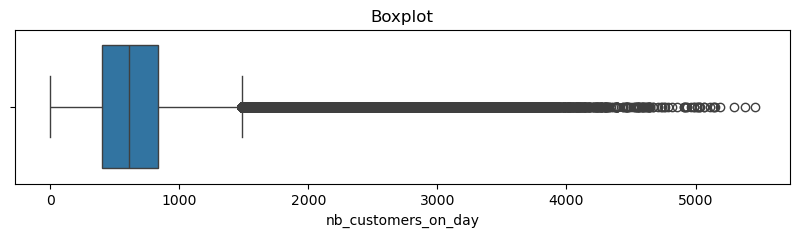

23941/640840 in nb_customers_on_day are potential outliers (0.04%)
Skewness: 1.59
Removed 23941 outliers


In [557]:
### HANDLING OUTLIERS ###

# Visualizing outliers through boxplots
plt.figure(figsize=(10,2))
sns.boxplot(x=sales_df['nb_customers_on_day'])
plt.title(f"Boxplot")
plt.show()

outl_indices = []

# Finding the upper (right) wishker for each Column in order to identify the potential outliers
perc25 = sales_df['nb_customers_on_day'].quantile(.25)
perc75 = sales_df['nb_customers_on_day'].quantile(.75)
outliers_threshold = perc75 + 1.5*(perc75 - perc25)

# Counting the outliers
outliers_count = sales_df['nb_customers_on_day'][sales_df['nb_customers_on_day'] >= outliers_threshold].count()
print(f"{outliers_count}/{sales_df['nb_customers_on_day'].shape[0]} in {'nb_customers_on_day'} are potential outliers ({(outliers_count/sales_df['nb_customers_on_day'].shape[0]).__round__(2)}%)")

# Removing outliers
outl_indices.extend(sales_df[sales_df['nb_customers_on_day'] >= outliers_threshold].index)

# Checking if any columns are positively or negatively skewed
print(f"Skewness: {sales_df['nb_customers_on_day'].skew().round(2)}")

# Dropping outliers and standarizing
no_outliers_df = sales_df.drop(outl_indices)
print(f"Removed {sales_df.shape[0] - no_outliers_df.shape[0]} outliers")

# We've observed that scaling performs better, so we'll use it instead of removing outliers
scaled_df = sales_df
scaled_df['nb_customers_on_day'] = pd.DataFrame(
    StandardScaler().fit_transform(
        sales_df[['nb_customers_on_day']]), columns=['nb_customers_on_day'])

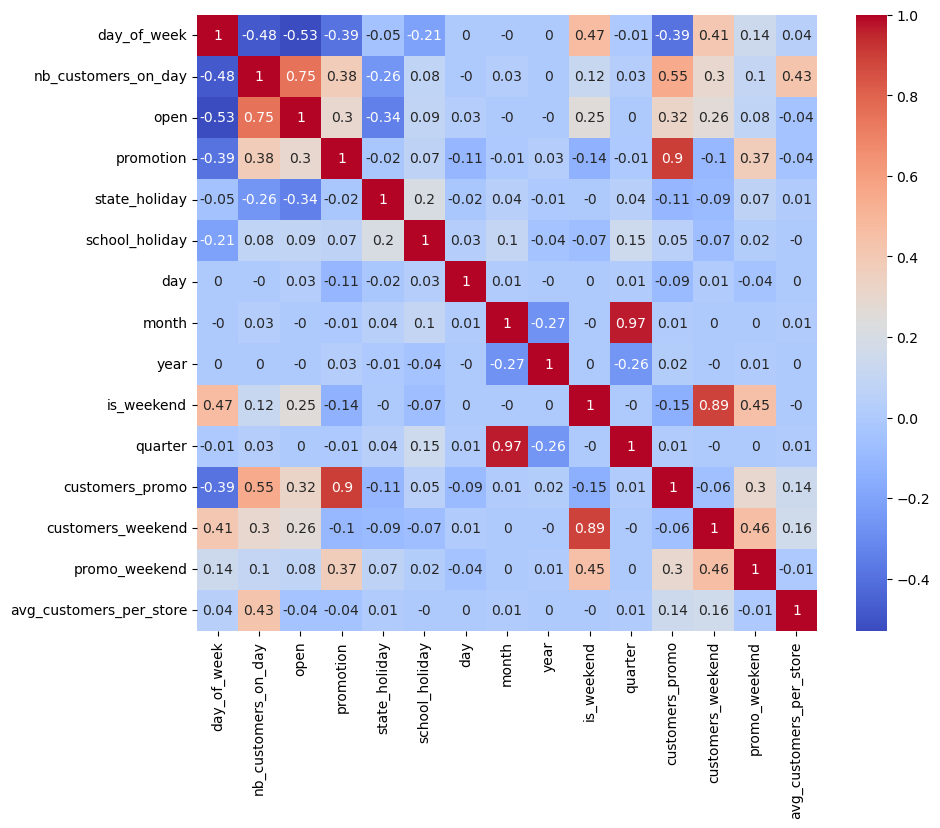

In [558]:
### Data Exploration ### TODO: Explore more ways to visualize the data (i.e: Feature importance graph)
### Pairs Plot ###
plot = False

if plot:
    sns.pairplot(sales_df.sample(100))
    plt.show()

# Ploting a heatmap of the correlation between the different columns
corr_df = no_outliers_df.drop(["Unnamed: 0", "store_ID", "date", "sales"], axis=1)
corr = corr_df.corr().round(2)
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.show()

# We'll drop "quarter" as we found out it has a hihg correlation with "month"

In [559]:
### K-Fold TESTING ###

""" from sklearn.model_selection import KFold

# Defining Features and Target an Standarizing the data
# TODO: SHOULD WE NORMALIZE?
X_scaled = StandardScaler().fit_transform(sales_df.drop('sales', axis=1))
X_scaled_real = StandardScaler().fit_transform(real_sales_df)
y = sales_df['sales']


# Spliting the data with K Folds
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True) #, random_state=42
sum_r2 =0

# Training and evaluating the model
for train_index, test_index in kf.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Initialize and fit the XGBoost Regressor model
    xgb_model = xgb.XGBRegressor().fit(X_train, y_train)
    y_pred = xgb_model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    sum_r2 += r2
    print(f'R² Score: {r2.round(4)}')
print(f'\nAverage R² Score: {(sum_r2/n_splits).round(4)}') """


" from sklearn.model_selection import KFold\n\n# Defining Features and Target an Standarizing the data\n# TODO: SHOULD WE NORMALIZE?\nX_scaled = StandardScaler().fit_transform(sales_df.drop('sales', axis=1))\nX_scaled_real = StandardScaler().fit_transform(real_sales_df)\ny = sales_df['sales']\n\n\n# Spliting the data with K Folds\nn_splits = 5\nkf = KFold(n_splits=n_splits, shuffle=True) #, random_state=42\nsum_r2 =0\n\n# Training and evaluating the model\nfor train_index, test_index in kf.split(X_scaled):\n    X_train, X_test = X_scaled[train_index], X_scaled[test_index]\n    y_train, y_test = y[train_index], y[test_index]\n    \n    # Initialize and fit the XGBoost Regressor model\n    xgb_model = xgb.XGBRegressor().fit(X_train, y_train)\n    y_pred = xgb_model.predict(X_test)\n\n    r2 = r2_score(y_test, y_pred)\n    sum_r2 += r2\n    print(f'R² Score: {r2.round(4)}')\nprint(f'\nAverage R² Score: {(sum_r2/n_splits).round(4)}') "

In [560]:
### FUNCTIONS ###
### EVALUATION FUNCTION ###
def m_eval(y_test: pd.DataFrame, y_pred: pd.DataFrame, model_name: str):
    # TODO:
    """_summary_

    Args:
        y_test (pd.DataFrame): _description_
        y_pred (pd.DataFrame): _description_
        model_name (str): _description_
    """

    # Create a mask to filter out zero values in 'y' for mape calculation
    mask = y_test != 0
    y_test_non_zero = y_test[mask]
    y_pred_non_zero = y_pred[mask]

    rmse = root_mean_squared_error(y_test, y_pred) # TODO: Remove because we have MSE...
    mape = mean_absolute_percentage_error(y_test_non_zero, y_pred_non_zero)
    r2 = r2_score(y_test, y_pred)
    print(f"{model_name.upper()} MODEL:")
    print(f"Root Mean Squared Error: {rmse.round(4)}")
    print(f"Mean Absolute Percentage Error: {mape * 100:.2f}%")
    print(f"R² Score: {r2.round(4)}\n")    

### SPLITTING THE DATA AND TRAINING THE MODEL ###
def build_train_ml(model_name: str, x: list, y: list):
    # TODO:
    """_summary_

    Args:
        model_name (str): _description_
        x (list): _description_
        y (list): _description_

    Returns:
        _type_: _description_
    """

    # Initializing and training the model
    if model_name == 'xgb':
        model = XGBRegressor(n_estimators=250, max_depth=8, learning_rate=0.3, reg_alpha=0, reg_lambda=0.5).fit(x, y)
    elif model_name == 'rf':
        model = RandomForestRegressor(n_estimators=100, max_depth=6, min_samples_split=5, min_samples_leaf=1).fit(x, y)
    else:
        raise ValueError(f"Invalid model name: {model_name}")

    return model

In [561]:
### Testing Hyperparameters ###
do_test_hp = False
if do_test_hp:
    # Dropping
    features_drop = ["Unnamed: 0", "date", "quarter", "sales"]

    # Defining Features and Target
    X = sales_df.drop(features_drop, axis=1)
    y = sales_df["sales"]

    # Splitting the data into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

    # I tried with more parameters in both models. I implemented the best ones in the final version, leaving this here for reference.
    # XGB Regressor
    reg_cv_xgb = GridSearchCV(XGBRegressor(), {
    'max_depth': [3, 6],
    'reg_alpha': [0, 0.5],
    'reg_lambda': [0.5, 1],
    'learning_rate': [0.01, 0.1, 0.3]}, verbose=2)
    
    reg_cv_xgb.fit(X_train,y_train)
    print(reg_cv_xgb.best_params_)

    # RF Regressor
    reg_cv_rf = GridSearchCV(RandomForestRegressor(), {
    'n_estimators':[10],
    'max_depth': [3, 6, 8],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]}, verbose=2)

    reg_cv_rf.fit(X_train,y_train)
    print(reg_cv_rf.best_params_)

In [562]:
### SPLITTING THE DATA ###

# Dropping unwanted features (some of them identified after training the model)
features_drop = ["Unnamed: 0", "date", "quarter", "sales", "school_holiday", "day", "year", "customers_promo", "customers_weekend", "promo_weekend"]

# Defining Features and Target
X = scaled_df.drop(features_drop, axis=1)
y = scaled_df["sales"]

# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)


In [563]:
### TRAINING AND EVALUATING XGB MODEL ###
# Building and training the model
xgb_model = build_train_ml('xgb', X_train, y_train)

# Making predicitions and evaluating
y_pred_xgb = xgb_model.predict(X_test)
m_eval(y_test, y_pred_xgb, "XGB")

XGB MODEL:
Root Mean Squared Error: 448.8734
Mean Absolute Percentage Error: 5.08%
R² Score: 0.9864



In [564]:
### TRAINING AND EVALUATING RF MODEL ###
# We won't use the RandomForestRegressor because of the low performance by comparison
# Building and training the model
rf_model = build_train_ml('rf', X_train, y_train)

# Making predicitions and evaluating
y_pred_rf = rf_model.predict(X_test)
m_eval(y_test, y_pred_rf, "RF")

RF MODEL:
Root Mean Squared Error: 1324.0158
Mean Absolute Percentage Error: 16.20%
R² Score: 0.8815



In [565]:
### ENSAMBLING BOTH MODELS ###
# The results are similar to using only one XGBRegressor so we won't use the ensambling

test_ensambling = False
if test_ensambling:
    # Create out-of-fold predictions for stacking
    oof_pred_xgb = cross_val_predict(xgb_model, X_train, y_train, cv=5)
    oof_pred_rf = cross_val_predict(rf_model, X_train, y_train, cv=5)

    # Train a meta-model on the combined predictions
    meta_model = Ridge().fit(np.column_stack((oof_pred_xgb, oof_pred_rf)), y_train)
    # The meta model using XGB to stack the previous models shows worse performance than only using one XGBRegressor
    #meta_model = XGBRegressor(n_estimators=500, max_depth=8, learning_rate=0.3, reg_alpha=0, reg_lambda=0.5).fit(stacked_predictions, y_train)

    # Predict using the meta-model on the stacked test set predictions
    final_pred = meta_model.predict(np.column_stack((y_pred_xgb, y_pred_rf)))

    # Evaluate the stacked model
    m_eval(y_test, final_pred, "META")

In [566]:
# Evaluate the model on multiple folds with cross validation
cv_scores = cross_val_score(xgb_model, X, y, cv=5, scoring='r2')
print("CROSS VALIDATION:")
print(f"Average R² score: {cv_scores.mean().round(4)}")
print(f'Standard Deviation: {cv_scores.std().round(4)}')

CROSS VALIDATION:
Average R² score: 0.9861
Standard Deviation: 0.0002


In [567]:
### TIME SERIES SPLIT ###
do_test_tst = False
if do_test_tst:
    # Splitting the data into train and test
    ts_split = TimeSeriesSplit(n_splits=5)

    # Defining Features and Target
    X_sorted = sorted_df.drop(features_drop, axis=1)
    y_sorted = sorted_df['sales']

    # Splitting the data into train and test
    for train_index, test_index in ts_split.split(sorted_df):
        X_train_s, X_test_s = X_sorted.iloc[train_index], X_sorted.iloc[test_index]
        y_train_s, y_test_s = y_sorted.iloc[train_index], y_sorted.iloc[test_index]

    # Building and training the model
    xgb_model_sorted = build_train_ml('xgb', X_train_s, y_train_s)

    # Making predicitions and evaluating
    y_pred_s = xgb_model_sorted.predict(X_test_s)
    m_eval(y_test_s, y_pred_s, "XGB")

    # Evaluate the model on multiple folds
    cv_scores_sorted = cross_val_score(xgb_model_sorted, X_sorted, y_sorted, cv=ts_split)
    print(f"Average R² score: {cv_scores_sorted.mean().round(4)}")
    print(f'Standard Deviation: {cv_scores_sorted.std().round(4)}')

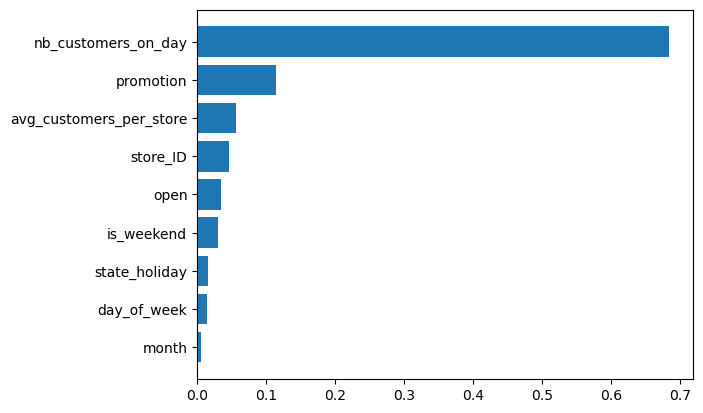

In [568]:
# Plotting feature importance for evaluation
sort_idx = xgb_model.feature_importances_.argsort() 
plt.barh(X.columns[sort_idx],xgb_model.feature_importances_[sort_idx])
plt.show();

In [574]:
# Reading the real data
real_sales_df = pd.read_csv('REAL_DATA.csv')

# Checking for missing data
print(f"Total missing data: {real_sales_df.isnull().sum().sum()}")

real_sales_df["sales"] = sales_df["sales"].fillna(0).astype('int64')

# Replace non-int data in the 'date' and 'state_holiday' columns with integers
real_sales_df['state_holiday'] = LabelEncoder().fit_transform(real_sales_df['state_holiday'])
real_sales_df['date'] = pd.to_datetime(real_sales_df['date'], format='%d/%m/%Y')

#Extract individual features from the date
real_sales_df['day'] = real_sales_df['date'].dt.day
real_sales_df['month'] = real_sales_df['date'].dt.month
real_sales_df['year'] = real_sales_df['date'].dt.year

# Extracting weekend information from the day of the week
real_sales_df['is_weekend'] = real_sales_df['day_of_week'].apply(lambda x: 1 if x in [5, 6] else 0)

# We've observed that scaling performs better, so we'll use it instead of removing outliers
real_sales_df['nb_customers_on_day'] = pd.DataFrame(
    StandardScaler().fit_transform(
        sales_df[['nb_customers_on_day']]), columns=['nb_customers_on_day'])

real_sales_df['avg_customers_per_store'] = real_sales_df.groupby('store_ID')['nb_customers_on_day'].transform('mean')

real_sales_clean_df = real_sales_df.drop(["index", "date", "sales", "school_holiday", "day", "year"], axis=1)

# Checking the result
real_sales_clean_df.head()

Total missing data: 0


,store_ID,day_of_week,nb_customers_on_day,open,promotion,state_holiday,month,is_weekend,avg_customers_per_store
0,415,7,-0.250808,0,0,0,3,0,0.118520
1,27,7,0.130580,0,0,0,12,0,-0.089418
2,404,3,0.725287,1,1,0,3,0,-0.101131
3,683,2,-0.345617,1,0,0,1,0,0.010957
4,920,3,0.936451,1,1,0,3,0,0.055021


In [575]:
# Making predicitions with the real data
y_pred_real_xgb = xgb_model.predict(real_sales_clean_df)

In [576]:
# Creating the CSV file to deliver
# TODO: Add index column back
real_sales_clean_df['sales'] = pd.DataFrame(y_pred_real_xgb, columns=['sales']).astype('int64')
real_sales_clean_df.to_csv('G5.csv', index=False)